### Importing required libaries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from models.old_model import SiameseNetwork

from losses.euclidean import ContrastiveLoss
from losses.cosine import ContrastiveLossCosine

from utils.vis_utils import imshow, show_plot
from utils.other_utils import joinpath, SiameseNetworkDataset, SiameseNetworkDataset_for_test, get_dataset
from utils.other_utils import intersection, threshold


In [2]:
# Setup the path where images are located
PATH = r"H:\Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning\data\faces"


# Setup the number of channels in the image, 3 for color, 1 for monochrome
nchannel=1

# no of epoch
EPOCH = 200

# if testing
testing = False

# Threshold score
THRESHOLD_SCORE = 0.3

In [3]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])

In [4]:
os.cpu_count() #cpu count

16

For simple visualization purposes let’s look at this example.  
Create a DataLoader of the siamese_dataset and extract the first batch only.  
Combine each combination of images, because our siamese_datasetwill return two images and one label, and print out the labels.

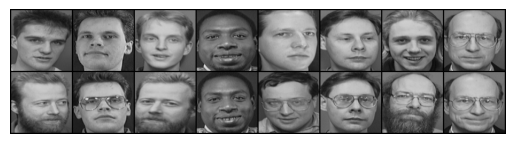

[1. 0. 1. 0. 1. 0. 1. 0.]


In [5]:
# Create a simple dataloader just for simple visualization
vis_dataloader,_ = get_dataset(joinpath(PATH,'train'),transformation,SiameseNetworkDataset,0,8,True)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [6]:
# Load the training dataset
train_dataloader,_ = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset, 0, 64, True)
net = SiameseNetwork(nchannel).cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [7]:
print(net)

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
)


In [8]:
from torchsummary import summary
summary(net, [(nchannel, 100, 100), (nchannel, 100, 100)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 23, 23]          11,712
              ReLU-2           [-1, 96, 23, 23]               0
         MaxPool2d-3           [-1, 96, 11, 11]               0
            Conv2d-4            [-1, 256, 7, 7]         614,656
              ReLU-5            [-1, 256, 7, 7]               0
         MaxPool2d-6            [-1, 256, 3, 3]               0
            Conv2d-7            [-1, 384, 1, 1]         885,120
              ReLU-8            [-1, 384, 1, 1]               0
            Linear-9                 [-1, 1024]         394,240
             ReLU-10                 [-1, 1024]               0
           Linear-11                  [-1, 256]         262,400
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
           Conv2d-14           [-1, 96,

Following the flow diagram from the top, we can start creating the training loop. We iterate 200 times and extract the two images as well as the label. We zero the gradients and pass our two images into the network, and the network outputs two vectors. The two vectors, and the label, are then fed into the criterion (loss function) that we defined. We backpropagate and optimize. For some visualization purposes and to see how our model is performing on the training set, so we will print the loss every 10 batches.

In [9]:
def train(epochs = EPOCH):

    counter = []
    loss_history = [] 
    iteration_number= 0

    # Iterate throught the epochs
    for epoch in range(epochs):

    # Iterate over batches
        for i, (img0, img1, label) in enumerate(train_dataloader, 0):

            # Send the images and labels to CUDA
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = net(img0, img1)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = criterion(output1, output2, label)

            # Calculate the backpropagation
            loss_contrastive.backward()

            # Optimize
            optimizer.step()

            # Every 10 batches print out the loss
            if i % 10 == 0 :
                print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
                iteration_number += 10

                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return (counter,loss_history)

Epoch number 0
 Current loss 2.0420994758605957

Epoch number 1
 Current loss 1.0838371515274048

Epoch number 2
 Current loss 0.9618706107139587

Epoch number 3
 Current loss 0.9897016286849976

Epoch number 4
 Current loss 0.955048143863678

Epoch number 5
 Current loss 0.6658613681793213

Epoch number 6
 Current loss 0.6432085633277893

Epoch number 7
 Current loss 0.4898185729980469

Epoch number 8
 Current loss 0.4707733690738678

Epoch number 9
 Current loss 0.37446820735931396

Epoch number 10
 Current loss 0.6816462278366089

Epoch number 11
 Current loss 0.405841201543808

Epoch number 12
 Current loss 0.5458012819290161

Epoch number 13
 Current loss 0.33923736214637756

Epoch number 14
 Current loss 0.4914356768131256

Epoch number 15
 Current loss 0.3717097043991089

Epoch number 16
 Current loss 0.3190779685974121

Epoch number 17
 Current loss 0.3262321352958679

Epoch number 18
 Current loss 0.39645057916641235

Epoch number 19
 Current loss 0.25924670696258545

Epoch nu

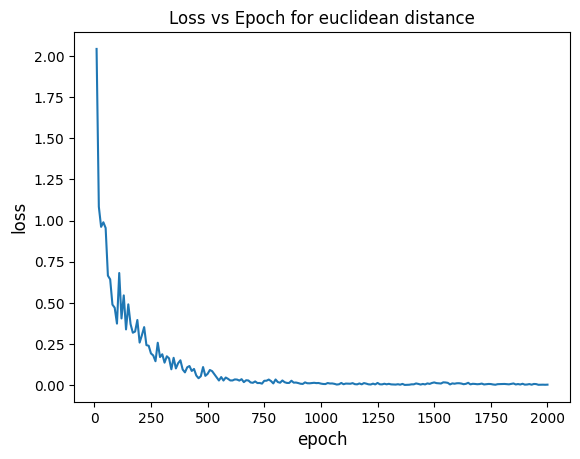

In [10]:
counter,loss_history = train(EPOCH)

# Plotting the loss vs epoch
plt.figure()
plt.title('Loss vs Epoch for euclidean distance')
plt.xlabel("epoch", fontsize=12)
plt.ylabel("loss", fontsize=12)
show_plot(counter, loss_history)

We can now analyze the results. The first thing we can see is that the loss started around 1.6 and ended at a number pretty close to 0.

It would be interesting to see the model in action. Now comes the part where we test our model on images it didn’t see before. As we have done before, we create a Siamese Network Dataset using our custom dataset class, but now we point it to the test folder.

As the next steps, we extract the first image from the first batch of the test set and iterate over all the train images to check how it performs.

We pass in the two images into the model and obtain two vectors, which are then passed into theF.pairwise_distance() function, this will calculate the euclidean distance between the two vectors. Using this distance, we can as a metric of how dissimilar the two faces are.

In [11]:
#### here we create dataiter for test

# Locate the test dataset and load it into the SiameseNetworkDataset_for_test
if testing:
    test_dataloader,_ = get_dataset(joinpath(PATH,'test'), transformation, SiameseNetworkDataset_for_test, 0, 1, True)

    # Grab one image that we are going to test
    dataiter = iter(test_dataloader)
    x0,_ = next(dataiter)


    #### here we create dataiter for train.

    # Locate the test dataset and load it into the SiameseNetworkDataset_for_test
    train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset_for_test, 0, 1, False)

    dataiter_train = iter(train_dataloader)

    score = []

    for i in range(len(siamese_dataset_train)):
        # Iterate over all images and test them with the first image (x0)
        x1,_ = next(dataiter_train)

        # Concatenate the two images together
        concatenated = torch.cat((x0, x1), 0)
        
        output1, output2 = net(x0.cuda(), x1.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        score.append(round(euclidean_distance.item(),2))
        imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
        # cosine_distance = torch.cosine_similarity(output1, output2)
        # score.append(round(cosine_distance.item(),2))
        # imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {cosine_distance.item():.2f}')

Now we test all the test images with all the train images and all combination are unique.

In [12]:
#### here we create dataiter for test

test_dataloader,siamese_dataset = get_dataset(joinpath(PATH,'test'), transformation, SiameseNetworkDataset_for_test, 0, 1, True)

#### here we create dataiter for train

train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset_for_test, 0, 1, False)


truth=[]
predict=[]
same_disssimilarity=[]
different_disssimilarity=[]
count_label0 = []
count_label1 = []


dataiter = iter(test_dataloader)
for i in range(len(siamese_dataset)):
    
    x0,label0 = next(dataiter)
    count_label0.append(label0)
    

# Grab one image that we are going to test
    dataiter_train = iter(train_dataloader)

    for i in range(len(siamese_dataset_train)):
    # Iterate over 5 images and test them with the first image (x0)
        x1,label1 = next(dataiter_train)
        count_label1.append(label1)

        # Concatenate the two images together
        concatenated = torch.cat((x0, x1), 0)

        output1, output2 = net(x0.cuda(), x1.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        

        predict.append(euclidean_distance.item())
        if label0==label1: # if labels of two images are same append them to same_dissimilar
            same_disssimilarity.append(euclidean_distance.item())
        else:
            different_disssimilarity.append(euclidean_distance.item())

        # cosine_distance = torch.cosine_similarity(output1, output2)
        # predict.append(cosine_distance.item())
        # if label0==label1:
        #     same_disssimilarity.append(cosine_distance.item())
        # else:
        #     different_disssimilarity.append(cosine_distance.item())

In [13]:
# checking if there are any intersection in same and different images
print("Number of total interesection: ", len(intersection(same_disssimilarity,different_disssimilarity)))

Number of total interesection:  0


C:\Users\AkshatGarg\AppData\Local\Temp\ipykernel_30572\3183135136.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(same_disssimilarity, bins=100, kde=True, hist=False, rug=False, label="Same", color=colors[0])
C:\Users\AkshatGarg\AppData\Local\Temp\ipykernel_30572\3183135136.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mw

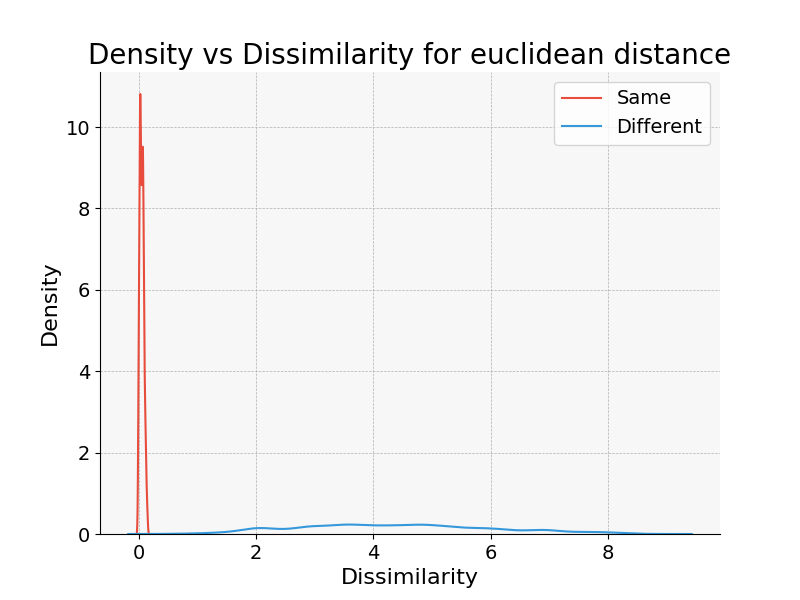

In [14]:
# Plotting the distribution for same vs dissimilar images density plot

%matplotlib widget
import seaborn as sns
import matplotlib.pyplot as plt

# Set custom color palette
colors = ["#E74C3C", "#3498DB"]

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(8, 6))

# Set background color
ax.set_facecolor("#F7F7F7")

# Plot the distributions and set custom colors
sns.distplot(same_disssimilarity, bins=100, kde=True, hist=False, rug=False, label="Same", color=colors[0])
sns.distplot(different_disssimilarity, bins=100, kde=True, hist=False, rug=False, label="Different", color=colors[1])

# Add legend and title
plt.legend(fontsize=14)
plt.title('Density vs Dissimilarity for euclidean distance', fontsize=20)

# Add gridlines
ax.grid(linestyle='--', linewidth=0.5)

# Set axis labels and tick sizes
plt.xlabel("Dissimilarity", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove top and right spines
sns.despine(top=True, right=True)

plt.show()

In [15]:
# checking for mean/average score
from statistics import mean
print("Mean of same images: ",mean(same_disssimilarity))
print("Mean of different images: ",mean(different_disssimilarity))

Mean of same images:  0.051242389989577836
Mean of different images:  4.3774091039945


In [16]:
# Prinitng total number of combinations that we tested on
print("Total number of combinations of same images: ", len(same_disssimilarity))
print("Total number of combinations of different images: ", len(different_disssimilarity))
print("Total number of combinations: ", len(same_disssimilarity) + len(different_disssimilarity))

Total number of combinations of same images:  300
Total number of combinations of different images:  21900
Total number of combinations:  22200


In [17]:
# Checking for number of missclassified images
final_list, same_misclassified, different_misclassified = threshold(same_disssimilarity,different_disssimilarity,THRESHOLD_SCORE)

print("Total number of missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(final_list))
print("Total number of same class missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(same_misclassified))
print("Total number of different class missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(different_misclassified))

Total number of missclassified for threshold score  0.3  missclassified images:  0
Total number of same class missclassified for threshold score  0.3  missclassified images:  0
Total number of different class missclassified for threshold score  0.3  missclassified images:  0
